In [35]:
import os
import cv2
import math
import numpy as np
from collections import OrderedDict
import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras import backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [36]:
np.random.seed(42)

In [37]:
INPUT_PATH = "../input/ck48-5-emotions/CK+48/"

total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    total_images += count
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images: {total_images}")

surprise has 249 number of images
fear has 75 number of images
sadness has 84 number of images
happy has 207 number of images
anger has 135 number of images

total images: 750


In [38]:
TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

In [39]:
img_arr = np.empty(shape=(total_images, 48, 48, 1))
img_label = np.empty(shape=(total_images))
label_to_text = {}

idx = 0
label = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in  TOP_EMOTIONS:
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[idx] = np.expand_dims(cv2.imread(INPUT_PATH + dir_ + "/" + f, 0), axis=2)
            img_label[idx] = label
            idx += 1
        label_to_text[label] = dir_
        label += 1

img_label = np_utils.to_categorical(img_label)

img_arr.shape, img_label.shape, label_to_text

((750, 48, 48, 1),
 (750, 5),
 {0: 'surprise', 1: 'fear', 2: 'sadness', 3: 'happy', 4: 'anger'})

In [40]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label, train_size=0.7, stratify=img_label, shuffle=True, random_state=42)
X_train.shape, X_test.shape

((525, 48, 48, 1), (225, 48, 48, 1))

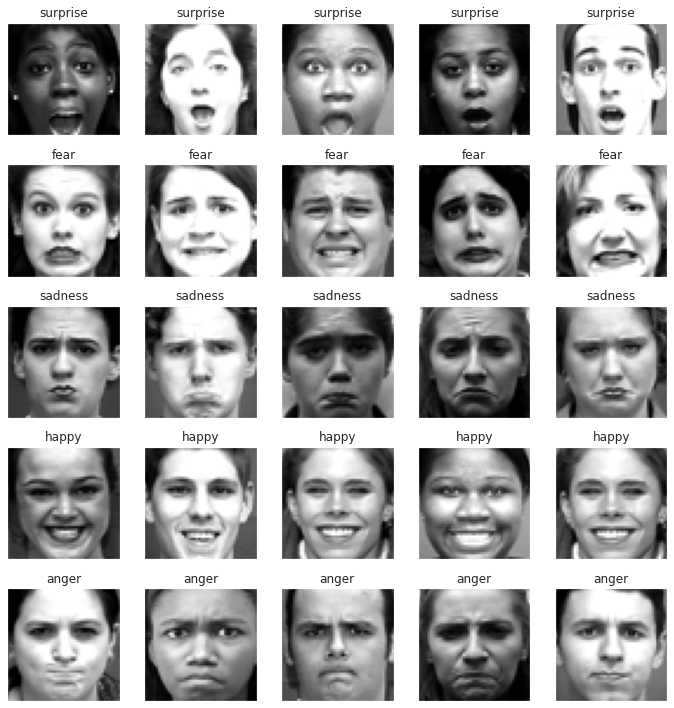

In [41]:
fig = pyplot.figure(1, (10,10))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(y_train[:,k]==1)[0], size=5, replace=False)
    sample_images = X_train[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(5,5,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

In [42]:
# data normalization
X_train = X_train / 255.
X_test = X_test / 255.

In [43]:
def build_dcnn(input_shape, num_classes):
    model_in = Input(shape=input_shape, name="input")
    
    conv2d_1 = Conv2D(
        filters=16,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1')(batchnorm_2)
    dropout_1 = Dropout(0.3, name='dropout_1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2')(batchnorm_4)
    dropout_2 = Dropout(0.3, name='dropout_2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3')(batchnorm_6)
    dropout_3 = Dropout(0.3, name='dropout_3')(maxpool2d_3)

    flatten = Flatten(name='flatten')(dropout_3)
    
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7')(dense_1)
    dropout_4 = Dropout(0.4, name='dropout_4')(batchnorm_7)

    model_out = Dense(
        num_classes,
        activation='softmax',
        name='out_layer'
    )(dropout_4)

    model = Model(inputs=model_in, outputs=model_out, name="DCNN")
    
    return model

In [44]:
INPUT_SHAPE = (48, 48, 1)
optim = optimizers.Adam(0.001)

model = build_dcnn(input_shape=(48,48,1), num_classes=len(label_to_text))
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

#plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='model.png')

In [45]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00008,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.4,
    patience=6,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    #early_stopping,
    
]

batch_size = 32
epochs = 100

In [46]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [47]:
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
16/16 [==============================] - 2s 47ms/step - loss: 2.1238 - accuracy: 0.3276 - val_loss: 4.1483 - val_accuracy: 0.4978
Epoch 2/100
16/16 [==============================] - 1s 29ms/step - loss: 1.4442 - accuracy: 0.4876 - val_loss: 3.3014 - val_accuracy: 0.3822
Epoch 3/100
16/16 [==============================] - 0s 22ms/step - loss: 1.1586 - accuracy: 0.5829 - val_loss: 1.2501 - val_accuracy: 0.6178
Epoch 4/100
16/16 [==============================] - 1s 28ms/step - loss: 1.0177 - accuracy: 0.6210 - val_loss: 1.0200 - val_accuracy: 0.7111
Epoch 5/100
16/16 [==============================] - 1s 29ms/step - loss: 0.9481 - accuracy: 0.6857 - val_loss: 0.9778 - val_accuracy: 0.6533
Epoch 6/100
16/16 [==============================] - 0s 24ms/step - loss: 0.8417 - accuracy: 0.6838 - val_loss: 1.4387 - val_accuracy: 0.5467
Epoch 7/100
16/16 [==============================] - 0s 22ms/step - loss: 0.7547 - accuracy: 0.7429 - val_loss: 1.4394 - val_accuracy: 0.5956
Epoch 

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-package

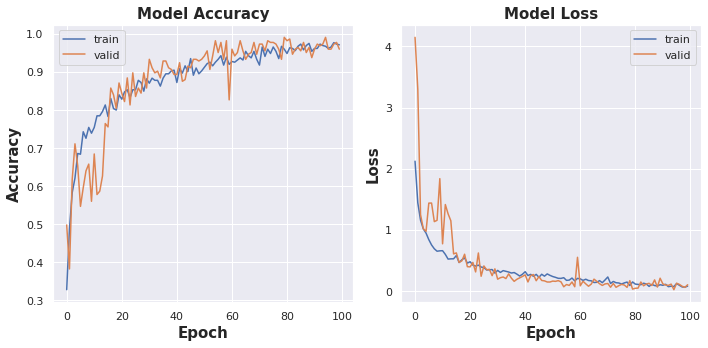

In [52]:
sns.set()
fig = pyplot.figure(0, (10, 5))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Model Accuracy', fontsize = 15, fontweight=1000)
pyplot.xlabel('Epoch', fontsize = 15, fontweight=700)
pyplot.ylabel('Accuracy', fontsize = 15, fontweight=700)
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Model Loss', fontsize = 15, fontweight=1000)
pyplot.xlabel('Epoch', fontsize = 15, fontweight=700)
pyplot.ylabel('Loss', fontsize = 15, fontweight=700)
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

In [61]:
y_pred = model.predict(X_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

[1, 0, 2, 2, 1, 0, 4, 0, 3, 3]

In [62]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[1, 0, 4, 2, 1, 0, 4, 0, 3, 3]

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        75
           1       1.00      0.86      0.93        22
           2       0.76      1.00      0.86        25
           3       1.00      1.00      1.00        62
           4       1.00      0.85      0.92        41

    accuracy                           0.96       225
   macro avg       0.95      0.94      0.94       225
weighted avg       0.97      0.96      0.96       225



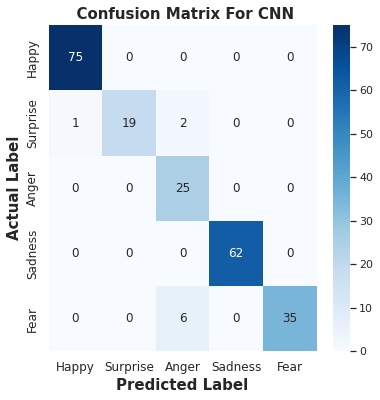

In [64]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

pyplot.figure(figsize = (6,6))
ax = pyplot.axes()
sn.heatmap(cm,cmap="Blues", annot = True, fmt = 'd')
ax.xaxis.set_ticklabels([  "Happy", "Surprise", "Anger", "Sadness", "Fear"], fontsize=12);
ax.yaxis.set_ticklabels([  "Happy", "Surprise", "Anger", "Sadness", "Fear"],  fontsize=12);

pyplot.title('  Confusion Matrix For CNN ', fontsize = 15, fontweight=1000)
pyplot.xlabel('Predicted Label', fontsize = 15, fontweight=1000)
pyplot.ylabel('Actual Label', fontsize = 15, fontweight=1000)


pyplot.savefig("Confusion Matrix")